In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exports.e_08_LambdaLayers import *

# Hooks
## Manually

In [3]:
class ManuallyHooked(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

### Convenience functions for building CNN

In [4]:
def conv_relu(n_inp, n_out, kernel_size=3, stride=2):
    return nn.Sequential(
            nn.Conv2d(n_inp, n_out,
                      kernel_size,
                      padding=kernel_size//2,
                      stride=stride),
            nn.ReLU())

    
def cnn_layers(data_w, n_kernels):
    n_kernels = [1] + n_kernels
    
    return [
        conv_relu(n_kernels[i], n_kernels[i+1], 5 if i==0 else 3)
        for i in range(len(n_kernels)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(n_kernels[-1], data_w.n_out)]

### Activation Means and Std Devs for each ReLU

In [5]:
kernel_ns = [8, 16, 32, 32]
data_w = MNISTDataWrapper()
model = ManuallyHooked(*cnn_layers(data_w, kernel_ns))

model_w = ModelWrapper(model,
                       optim.SGD(model.parameters(), lr=0.3),
                       torch.functional.F.cross_entropy,
                       data_w)

job = DLJob([AvgStatsCB(),
            BatchTransformCB(mnist_view)])
job.fit(1, model_w)

train: [2.20189140625]
valid: [1.15769345703125]


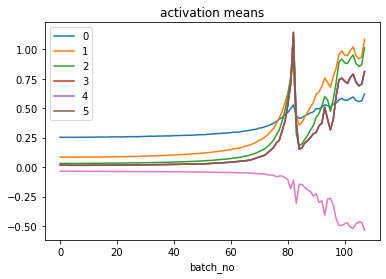

In [9]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6)); plt.xlabel('batch_no'); plt.title('activation means')
plt.show()

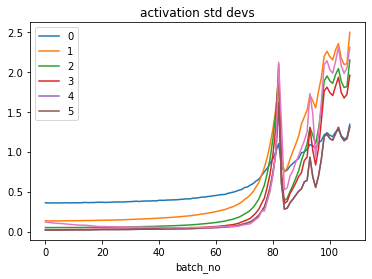

In [10]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6)); plt.xlabel('batch_no'); plt.title('activation std devs')
plt.show()